In [1186]:
import cv2
import numpy as np
import os
import time
import scipy.io as sio
import matplotlib.pyplot as plt
import math
import main_functions as main

In [1187]:
# main
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
# from cnn import get_mini_batch, fc, relu, conv, pool2x2, flattening
# from cnn import train_slp_linear, train_slp, train_mlp, train_cnn

In [1188]:
def visualize_confusion_matrix(confusion, accuracy, label_classes, name):
    plt.title("{}, accuracy = {:.3f}".format(name, accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.show()


In [1189]:
def get_mini_batch(im_train, label_train, batch_size):
    labels = [0,1,2,3,4,5,6,7,8,9]
    
    indices = np.arange(im_train.shape[1])
    np.random.shuffle(indices)
    
    im_train = im_train.T
    label_train = label_train.T
    
    shuffled_im = im_train[indices]
    shuffled_label = label_train[indices]
    
    shuffled_im = shuffled_im.T
    shuffled_label=shuffled_label.T
    
    i = 0
    mini_batch_x = []
    mini_batch_y = []

    while i < shuffled_im.shape[1]:
        temp_x = []
        temp_y = []
        for j in range(i, i+batch_size):
            if j == shuffled_im.shape[1]:
                break
            else:
                temp_x.append(shuffled_im[:, j])
                temp_label = np.zeros(10)
                temp_label[labels.index(shuffled_label[0, j])] = 1
                temp_y.append(temp_label)
        i += batch_size

        mini_batch_x.append(np.array(temp_x))
        mini_batch_y.append(np.array(temp_y))
    
    mini_batch_x = np.array(mini_batch_x)
    mini_batch_y = np.array(mini_batch_y)
    
    return mini_batch_x, mini_batch_y

In [1190]:
mnist_train = sio.loadmat('./mnist_train.mat')
mnist_test = sio.loadmat('./mnist_test.mat')
im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
batch_size = 32
im_train, im_test = im_train / 255.0, im_test / 255.0
mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)

In [1192]:
def fc(x, w, b):
    y = w @ x + b
    return y


In [1193]:
def fc_backward(dl_dy, x, w, b, y):
    # TO DO
    n = dl_dy.shape[1]
    m = x.shape[0]
    
    dl_dx = dl_dy @ w
    
    dy_dw = np.zeros((n, n, m))
    for i in range(n):
        dy_dw[i][i] = x.T
    dl_dw = dl_dy @ dy_dw
    
    dl_db = dl_dy.T
    
    return dl_dx, dl_dw, dl_db

In [1194]:
def loss_euclidean(y_tilde, y):
    # TO DO
    l = np.linalg.norm(y-y_tilde)
    dl_dy = -2*(y-y_tilde).T
    return l, dl_dy

In [1197]:
def train_slp_linear(mini_batch_x, mini_batch_y):
    # TO DO

    learn_rate = .1
    num_iterations = 5000
    decay_rate = .1
    weights = np.random.randn(10, 196)
    bias = np.zeros((10,1))
    k = 0
    for i in range(num_iterations):
        if i % 1000 == 0:
            learn_rate = learn_rate*decay_rate
            print(learn_rate)
        dL_dw = np.zeros((10, 196))
        dL_db = np.zeros((10, 1))
        for j in range(mini_batch_x[k].shape[0]):
            inp = np.reshape(mini_batch_x[k][j],(196,1))
            predict = fc(inp, weights, bias)
            loss, dl_dy = loss_euclidean(predict, np.reshape(mini_batch_y[k][j], (10,1)))
            dl_dx, dl_dw, dl_db = fc_backward(dl_dy, inp, weights, bias, predict)
            dL_dw = dL_dw + dl_dw[:,0,:]
            dL_db = dL_db + dl_db
        k += 1
        if k > mini_batch_x[k].shape[0]:
            k = 0
        weights = weights - learn_rate*dL_dw/32
        bias = bias - learn_rate*dL_db/32
    
    return weights, bias

In [1198]:
mnist_train = sio.loadmat('./mnist_train.mat')
mnist_test = sio.loadmat('./mnist_test.mat')
im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
batch_size = 32
im_train, im_test = im_train / 255.0, im_test / 255.0
mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
w, b = train_slp_linear(mini_batch_x, mini_batch_y)
sio.savemat('slp_linear.mat', mdict={'w': w, 'b': b})


0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06


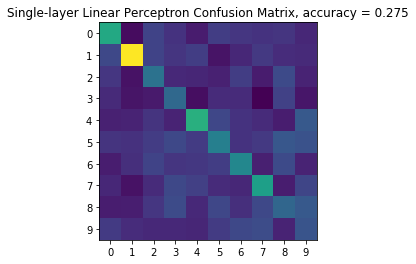

In [1199]:
acc = 0
confusion = np.zeros((10, 10))
num_test = im_test.shape[1]
for i in range(num_test):
    x = im_test[:, [i]]
    y = fc(x, w, b)
    l_pred = np.argmax(y)
    confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

    if l_pred == label_test[0, i]:
        acc = acc + 1
accuracy = acc / num_test
for i in range(10):
    confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
visualize_confusion_matrix(confusion, accuracy, label_classes, 'Single-layer Linear Perceptron Confusion Matrix')

In [1200]:
def main_slp_linear():
    mnist_train = sio.loadmat('./mnist_train.mat')
    mnist_test = sio.loadmat('./mnist_test.mat')
    im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
    im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
    batch_size = 32
    im_train, im_test = im_train / 255.0, im_test / 255.0
    mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
    w, b = train_slp_linear(mini_batch_x, mini_batch_y)
    sio.savemat('slp_linear.mat', mdict={'w': w, 'b': b})

    acc = 0
    confusion = np.zeros((10, 10))
    num_test = im_test.shape[1]
    for i in range(num_test):
        x = im_test[:, [i]]
#         print(x.shape)
        y = fc(x, w, b)
        print(y)
        l_pred = np.argmax(y)
        confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

        if l_pred == label_test[0, i]:
            acc = acc + 1
    accuracy = acc / num_test
    for i in range(10):
        confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, accuracy, label_classes, 'Single-layer Linear Perceptron Confusion Matrix')

In [1201]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

In [256]:
def derivative_of_softmax(x, index):
    derivative = np.zeros((x.shape[0], 1))
    
    exp_sum = np.sum(np.exp(x))
    for i in range(x.shape[0]):
        temp = 0
        if i == index:
            temp = exp_sum*np.exp(x[i]) - (np.exp(x[i])*np.exp(x[i]))
            temp = temp/exp_sum
            temp = temp/exp_sum
            derivative[i] = temp
        else:
            temp = -np.exp(x[i])*np.exp(x[index])
            temp = temp/exp_sum
            temp = temp/exp_sum
            derivative[i] = temp

    return derivative

In [749]:
def loss_cross_entropy_softmax(x, y):
    smax = softmax(x)
    log_softmax = np.log(smax)
    l = np.sum(np.multiply(y, log_softmax))/10
    
#     inverse_softmax = 1/smax
#     product = np.multiply(y, inverse_softmax)
#     dl_dy = np.zeros((1,y.shape[0]))
#     for i in range(y.shape[0]):
#         dl_dy[0][i] = -np.sum(np.multiply(product, derivative_of_softmax(x, i)))
#     print("one")
#     print(dl_dy)
#     temp = dl_dy
        
    dl_dy = softmax(x) - y
    dl_dy = np.reshape(dl_dy, (1,10))
    
    return l, dl_dy

In [1202]:
def loss_cross_entropy_softmax(x, y):
    smax = softmax(x)
    log_softmax = np.log(smax)
    l = np.sum(np.multiply(y, log_softmax))/10
        
    dl_dy = softmax(x) - y
    dl_dy = np.reshape(dl_dy, (1,10))
    
    return l, dl_dy

In [1207]:
def train_slp(mini_batch_x, mini_batch_y):
    learn_rate = .5
    num_iterations = 5000
    decay_rate = .9
    weights = np.random.randn(10, 196)
    bias = np.zeros((10,1))
    k = 0
    losses = []
    for i in range(num_iterations):
        if i % 1000 == 0 and i > 0:
            learn_rate = learn_rate*decay_rate
            print(learn_rate)
        dL_dw = np.zeros((10, 196))
        dL_db = np.zeros((10, 1))
        for j in range(mini_batch_x[k].shape[0]):
            inp = np.reshape(mini_batch_x[k][j],(196,1))
            predict = fc(inp, weights, bias)
            loss, dl_dy = loss_cross_entropy_softmax(predict, np.reshape(mini_batch_y[k][j], (10,1)))
            losses.append(loss)
            dl_dx, dl_dw, dl_db = fc_backward(dl_dy, inp, weights, bias, predict)
            dL_dw = dL_dw + dl_dw[:,0,:]
            dL_db = dL_db + dl_db
        k += 1
        if k > mini_batch_x[k].shape[0]:
            k = 0
        weights = weights - learn_rate*dL_dw/32
        bias = bias - learn_rate*dL_db/32
    
    return weights, bias, losses

In [1208]:
mnist_train = sio.loadmat('./mnist_train.mat')
mnist_test = sio.loadmat('./mnist_test.mat')
im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
batch_size = 32
im_train, im_test = im_train / 255.0, im_test / 255.0
mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
w, b, losses = train_slp(mini_batch_x, mini_batch_y)
sio.savemat('slp.mat', mdict={'w': w, 'b': b})

0.45
0.405
0.36450000000000005
0.32805000000000006


In [539]:
sio.savemat('slp_862.mat', mdict={'w': w, 'b': b})

In [1210]:
data = sio.loadmat('slp_862.mat')
w,b = data['w'], data['b']

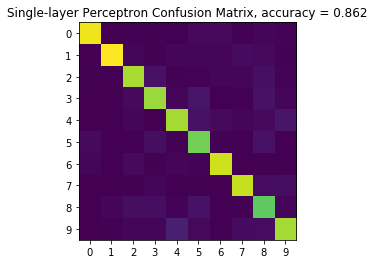

In [1211]:
acc = 0
confusion = np.zeros((10, 10))
num_test = im_test.shape[1]
for i in range(num_test):
    x = im_test[:, [i]]
    y = fc(x, w, b)
    l_pred = np.argmax(y)
    confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

    if l_pred == label_test[0, i]:
        acc = acc + 1
accuracy = acc / num_test
for i in range(10):
    confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
visualize_confusion_matrix(confusion, accuracy, label_classes, 'Single-layer Perceptron Confusion Matrix')

In [ ]:
def main_slp():
    mnist_train = sio.loadmat('./mnist_train.mat')
    mnist_test = sio.loadmat('./mnist_test.mat')
    im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
    im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
    batch_size = 32
    im_train, im_test = im_train / 255.0, im_test / 255.0
    mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
    w, b = train_slp(mini_batch_x, mini_batch_y)
    sio.savemat('slp.mat', mdict={'w': w, 'b': b})

    acc = 0
    confusion = np.zeros((10, 10))
    num_test = im_test.shape[1]
    for i in range(num_test):
        x = im_test[:, [i]]
        y = fc(x, w, b)
        l_pred = np.argmax(y)
        confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

        if l_pred == label_test[0, i]:
            acc = acc + 1
    accuracy = acc / num_test
    for i in range(10):
        confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, accuracy, label_classes, 'Single-layer Perceptron Confusion Matrix')

In [1212]:
def relu(x):
#     y = np.maximum(x, 0)
    # leaky
    y = np.maximum(x, .01*x)
    return y

In [1213]:
def relu_backward(dl_dy, x, y):
    dy_dx = x > 0
    dy_dx = dy_dx.astype(int)
    # leaky
    dy_dx[dy_dx < 0] = .01
    
    dl_dx = dl_dy * dy_dx.T
    
    return dl_dx

In [1215]:
def train_mlp(mini_batch_x, mini_batch_y):
    learn_rate = .5
    num_iterations = 5000
    decay_rate = .9
    w1 = np.random.randn(30, 196)
    b1 = np.zeros((30,1))
    w2 = np.random.randn(10, 30)
    b2 = np.zeros((10,1))
    k = 0
    for i in range(num_iterations):
        if i % 1000 == 0 and i > 0:
            learn_rate = learn_rate*decay_rate
            print(learn_rate)
        dL_dw2 = np.zeros((10, 30))
        dL_db2 = np.zeros((10, 1))
        dL_dw1 = np.zeros((30, 196))
        dL_db1 = np.zeros((30, 1))
        for j in range(mini_batch_x[k].shape[0]):
            inp = np.reshape(mini_batch_x[k][j],(196,1))
            predict1 = fc(inp, w1, b1)
            activated = relu(predict1)
            predict2 = fc(activated, w2, b2)
            loss, dl_dy2 = loss_cross_entropy_softmax(predict2, np.reshape(mini_batch_y[k][j], (10,1)))
            dl_dx2, dl_dw2, dl_db2 = fc_backward(dl_dy2, activated, w2, b2, predict2)
            dl_dy1 = relu_backward(dl_dx2, predict1, activated)
            dl_dx1, dl_dw1, dl_db1 = fc_backward(dl_dy1, inp, w1, b1, predict1)
            dL_dw2 = dL_dw2 + dl_dw2[:,0,:]
            dL_db2 = dL_db2 + dl_db2
            dL_dw1 = dL_dw1 + dl_dw1[:,0,:]
            dL_db1 = dL_db1 + dl_db1
        k += 1
        if k > mini_batch_x[k].shape[0]:
            k = 0
        w1 = w1 - learn_rate*dL_dw1/32
        b1 = b1 - learn_rate*dL_db1/32
        w2 = w2 - learn_rate*dL_dw2/32
        b2 = b2 - learn_rate*dL_db2/32
    return w1, b1, w2, b2

In [1216]:
mnist_train = sio.loadmat('./mnist_train.mat')
mnist_test = sio.loadmat('./mnist_test.mat')
im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
batch_size = 32
im_train, im_test = im_train / 255.0, im_test / 255.0
mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
w1, b1, w2, b2 = train_mlp(mini_batch_x, mini_batch_y)
sio.savemat('mlp.mat', mdict={'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2})

0.45
0.405
0.36450000000000005
0.32805000000000006


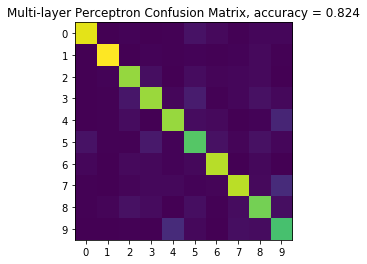

In [1217]:
acc = 0
confusion = np.zeros((10, 10))
num_test = im_test.shape[1]
for i in range(num_test):
    x = im_test[:, [i]]
    pred1 = fc(x, w1, b1)
    pred2 = relu(pred1)
    y = fc(pred2, w2, b2)
    l_pred = np.argmax(y)
    confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

    if l_pred == label_test[0, i]:
        acc = acc + 1
accuracy = acc / num_test
for i in range(10):
    confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
visualize_confusion_matrix(confusion, accuracy, label_classes, 'Multi-layer Perceptron Confusion Matrix')

In [ ]:
def main_mlp():
    mnist_train = sio.loadmat('./mnist_train.mat')
    mnist_test = sio.loadmat('./mnist_test.mat')
    im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
    im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
    batch_size = 32
    im_train, im_test = im_train / 255.0, im_test / 255.0
    mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
    w1, b1, w2, b2 = train_mlp(mini_batch_x, mini_batch_y)
    sio.savemat('mlp.mat', mdict={'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2})

    acc = 0
    confusion = np.zeros((10, 10))
    num_test = im_test.shape[1]
    for i in range(num_test):
        x = im_test[:, [i]]
        pred1 = fc(x, w1, b1)
        pred2 = relu(pred1)
        y = fc(pred2, w2, b2)
        l_pred = np.argmax(y)
        confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

        if l_pred == label_test[0, i]:
            acc = acc + 1
    accuracy = acc / num_test
    for i in range(10):
        confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, accuracy, label_classes, 'Multi-layer Perceptron Confusion Matrix')

# skip im2col for now

In [839]:
def im2col(x,hh,ww):
    h, w, c = x.shape
    new_h = (h-hh) + 1
    new_w = (w-ww) + 1
    col = np.zeros([new_h*new_w,c*hh*ww])

    for i in range(new_h):
        for j in range(new_w):
            patch = x[i:i+hh,j:j+ww, ...]
            col[i*new_w+j,:] = np.reshape(patch,-1)
    return col.T

In [872]:
def reshape_weights(w):
    h, width, c1, c2 = w.shape
    new = np.reshape(w, ((h*width*c1), c2))
    return new.T

In [1122]:
test = np.arange(3*3*1*3)
# print(test)
test = np.reshape(test, (3, 3, 1, 3))
# print(test[:,:,:,0])
# print(test[:,:,:,0].shape)

reshaped = reshape_weights(test)
print(reshaped.shape)

(3, 9)


In [1127]:
inp = np.reshape(mini_batch_x[0][0],(14,14,1))
pad_inp = np.lib.pad(inp, ((1,1),(1,1),(0,0)),'constant', constant_values=0)

reshape_inp = im2col(pad_inp,3,3)
print(reshape_inp.shape)

product = (reshaped @ reshape_inp)
print(product.shape)
final = np.reshape(product, (14, 14, 3))
print(final.shape)

(9, 196)
(3, 196)
(14, 14, 3)


In [1131]:
def conv(x, w_conv, b_conv):
    H, W, c1 = x.shape
    h, w, c1, c2 = w_conv.shape

    pad_x = np.lib.pad(x, ((1,1),(1,1),(0,0)),'constant', constant_values=0)
    
    y = np.zeros((H, W, c2))
#     print(y.shape)
    
    reshaped_w = reshape_weights(w_conv)
    reshaped_inp = im2col(pad_x, h, w)
    product = reshaped_w @ reshaped_inp
    h, w = product.shape
    for i in range(h):
        product[i, :] += b_conv[i, 0]
    y = np.reshape(product, (14,14,3))
    
    # TO DO
    return y

In [1137]:
def conv_backward(dl_dy, x, w_conv, b_conv, y):
    # TO DO
    # dl_dw is h * w * c1 * c2
    # dl_dy out of the relu layer is the same as out of the pool layer
    # dl_db is c2 * 1
    h, w, c1 = x.shape
    hh, ww, c1, c2 = w_conv.shape
    
    dl_dw = np.zeros_like(w_conv)
    dl_db = np.zeros_like(b_conv)
    dl_db = np.sum(dl_dy, axis=(0,1))
    
    reshaped_dy = np.reshape(dl_dy, (3, 196))
    
    pad_x = np.lib.pad(x, ((1,1),(1,1),(0,0)),'constant', constant_values=0)
    im_col = im2col(pad_x, hh, ww)
    
#     print(reshaped_dy.shape)
#     print(im_col.shape)
    
    product = reshaped_dy @ im_col.T
    dl_d2 = np.reshape(product, (3,3,1,3))
    
    return dl_dw, dl_db

# this actually works I think

In [940]:
def conv(x, w_conv, b_conv):
    H, W, c1 = x.shape
    h, w, c1, c2 = w_conv.shape

    pad_x = np.lib.pad(x, ((1,1),(1,1),(0,0)),'constant', constant_values=0)
    
    y = np.zeros((H, W, c2))
#     print(y.shape)
    
    for N in range(c2):
        for depth in range(c1):
            for i in range(H):
                for j in range(W):
#                     print(x[i:i+h, j:j+w, depth])
#                     print(w_conv[:,:,depth,N])
                    y[i, j, N] = np.sum(pad_x[i:i+h, j:j+w, depth] * w_conv[:,:,depth,N]) + b_conv[N][0]
    
    # TO DO
    return y

In [939]:
inp = np.reshape(mini_batch_x[0][0],(14,14,1), order='F')
test_w = np.random.randn(3,3,1,3)
test_b = np.random.randn(3, 1)

final = conv(inp, test_w, test_b)
print(conv(inp, test_w, test_b).shape)

dl_dy = np.random.randn(14, 14, 3)

_, _ = conv_backward(dl_dy, inp, test_w_, test_b, final)

(14, 14, 3)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[-0.44891185 -0.65178188 -0.79514306]
 [ 0.00542301 -0.64199287  0.03839081]
 [ 0.09776678 -2.35355709 -0.97642303]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[-0.44891185 -0.65178188 -0.79514306]
 [ 0.00542301 -0.64199287  0.03839081]
 [ 0.09776678 -2.35355709 -0.97642303]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[-0.44891185 -0.65178188 -0.79514306]
 [ 0.00542301 -0.64199287  0.03839081]
 [ 0.09776678 -2.35355709 -0.97642303]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[-0.44891185 -0.65178188 -0.79514306]
 [ 0.00542301 -0.64199287  0.03839081]
 [ 0.09776678 -2.35355709 -0.97642303]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[-0.44891185 -0.65178188 -0.79514306]
 [ 0.00542301 -0.64199287  0.03839081]
 [ 0.09776678 -2.35355709 -0.97642303]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[-0.44891185 -0.65178188 -0.79514306]
 [ 0.00542301 -0.64199287  0.03839081]
 [ 0.09776678 -2.35355709 -0.97642303]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[-0.44891185 -0.6517

[[0.         0.         0.99215686]
 [0.         0.65882353 0.92941176]
 [0.         0.         0.        ]]
[[ 0.34858577 -0.42862192  0.26788169]
 [ 0.82937486  1.39132553  0.48010591]
 [-0.5169466   0.1128586   0.33808972]]
[[0.         0.99215686 0.        ]
 [0.65882353 0.92941176 0.        ]
 [0.         0.         0.        ]]
[[ 0.34858577 -0.42862192  0.26788169]
 [ 0.82937486  1.39132553  0.48010591]
 [-0.5169466   0.1128586   0.33808972]]
[[0.99215686 0.         0.        ]
 [0.92941176 0.         0.        ]
 [0.         0.         0.        ]]
[[ 0.34858577 -0.42862192  0.26788169]
 [ 0.82937486  1.39132553  0.48010591]
 [-0.5169466   0.1128586   0.33808972]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 0.34858577 -0.42862192  0.26788169]
 [ 0.82937486  1.39132553  0.48010591]
 [-0.5169466   0.1128586   0.33808972]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 0.34858577 -0.42862192  0.26788169]
 [ 0.82937486  1.39132553  0.48010591]
 [-0.5169466   0.1128586   0.33808972]]
[[0. 0. 0

 [ 0.09776678 -2.35355709 -0.97642303]]
[[0.99607843 0.03137255 0.        ]
 [0.91372549 0.         0.        ]
 [0.23921569 0.         0.        ]]
[[-0.44891185 -0.65178188 -0.79514306]
 [ 0.00542301 -0.64199287  0.03839081]
 [ 0.09776678 -2.35355709 -0.97642303]]
[[0.03137255 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[-0.44891185 -0.65178188 -0.79514306]
 [ 0.00542301 -0.64199287  0.03839081]
 [ 0.09776678 -2.35355709 -0.97642303]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[-0.44891185 -0.65178188 -0.79514306]
 [ 0.00542301 -0.64199287  0.03839081]
 [ 0.09776678 -2.35355709 -0.97642303]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[-0.44891185 -0.65178188 -0.79514306]
 [ 0.00542301 -0.64199287  0.03839081]
 [ 0.09776678 -2.35355709 -0.97642303]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[-0.44891185 -0.65178188 -0.79514306]
 [ 0.00542301 -0.64199287  0.03839081]
 [ 0.09776678 -2.35355709 -0.97642303]]
[[0. 0.]
 [0. 0.]
 [0. 0.]]
[[-0.44891185

[[-1.18236187  0.53355694 -1.64899104]
 [-1.32040111  2.13631156 -1.66323705]
 [ 0.50061692  2.26058723  1.41348762]]
[[0.89803922 0.99215686 0.25098039]
 [0.         0.99607843 0.03137255]
 [0.50196078 0.91372549 0.        ]]
[[-1.18236187  0.53355694 -1.64899104]
 [-1.32040111  2.13631156 -1.66323705]
 [ 0.50061692  2.26058723  1.41348762]]
[[0.99215686 0.25098039 0.        ]
 [0.99607843 0.03137255 0.        ]
 [0.91372549 0.         0.        ]]
[[-1.18236187  0.53355694 -1.64899104]
 [-1.32040111  2.13631156 -1.66323705]
 [ 0.50061692  2.26058723  1.41348762]]
[[0.25098039 0.         0.        ]
 [0.03137255 0.         0.        ]
 [0.         0.         0.        ]]
[[-1.18236187  0.53355694 -1.64899104]
 [-1.32040111  2.13631156 -1.66323705]
 [ 0.50061692  2.26058723  1.41348762]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[-1.18236187  0.53355694 -1.64899104]
 [-1.32040111  2.13631156 -1.66323705]
 [ 0.50061692  2.26058723  1.41348762]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[-1.1823

NameError: name 'test_w_' is not defined

In [949]:
def conv_backward(dl_dy, x, w_conv, b_conv, y):
    # TO DO
    # dl_dw is h * w * c1 * c2
    # dl_dy out of the relu layer is the same as out of the pool layer
    # dl_db is c2 * 1
    h, w, c1 = x.shape
    hh, ww, c1, c2 = w_conv.shape
        
    dl_dw = np.zeros_like(w_conv)
    dl_db = np.zeros_like(b_conv)
    dl_db = np.sum(dl_dy, axis=(0,1))
    
    pad_x = np.lib.pad(x, ((1,1),(1,1),(0,0)),'constant', constant_values=0)
    
    for a in range(c2):
        for i in range(hh):
            for j in range(ww):
                for k in range(h):
                    for l in range(w):
                        for b in range(c1):
                            dl_dw[i, j, b, a] += pad_x[i+k, j+l, b] * dl_dy[k, l, a]
    
    return dl_dw, dl_db

In [950]:
inp = np.reshape(mini_batch_x[0][0],(14,14,1), order='F')
test_w = np.random.randn(3,3,1,3)
test_b = np.random.randn(3, 1)

final = conv(inp, test_w, test_b)
print(conv(inp, test_w, test_b).shape)

dl_dy = np.random.randn(14, 14, 3)

dl_dw, dl_db = conv_backward(dl_dy, inp, test_w, test_b, final)
print(dl_dw.shape)
print(dl_db.shape)

(14, 14, 3)
(3, 3, 1, 3)
(3,)


In [958]:
def pool2x2(x):
    h, w, c = x.shape
    y = np.zeros((h//2, w//2, c))
    for i in range(h//2):
        for j in range(w//2):
            for k in range(c):
                y[i,j,k] = np.amax(x[i*2:i*2+2, j*2:j*2+2,k])
    return y

In [1218]:
def pool2x2_backward(dl_dy, x, y):
    # TO DO
    dl_dx = np.zeros_like(x)
#     print("dldx")
#     print(dl_dx.shape)
    
    h,w,c = x.shape
    
    for i in range(h//2):
        for j in range(w//2):
            for k in range(c):
                temp = np.amax(x[i*2:i*2+2, j*2:j*2+2,k])
                for m in range(2):
                    for n in range(2):
                        if x[i*2+m, j*2+n, k] == temp and temp !=0:
                            dl_dx[i*2+m, j*2+n, k] = dl_dy[i, j, k]
                        else:
                            dl_dx[i*2+m, j*2+n, k] = 0
    
    return dl_dx

(7, 7, 1)


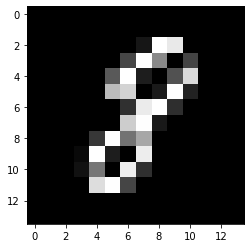

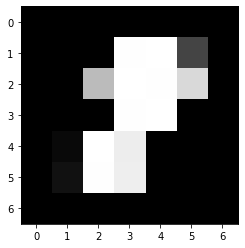

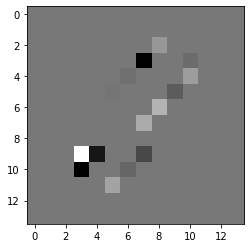

In [1063]:
inp = np.reshape(mini_batch_x[0][0],(14,14,1), order='F')
# print(inp)
print(pool2x2(inp).shape)
pooled = pool2x2(inp)

plt.imshow(inp.reshape((14, 14), order='F'), cmap='gray')
plt.show()
plt.imshow(pooled.reshape((7, 7), order='F'), cmap='gray')
plt.show()

dl_dy = np.random.randn(7,7,1)
# print(dl_dy)


backward = pool2x2_backward(dl_dy, inp, pooled)
plt.imshow(backward.reshape((14, 14), order='F'), cmap='gray')
plt.show()

In [1029]:
def flattening(x):
    return x.flatten('F').reshape((x.size, 1))

In [964]:
def flattening_backward(dl_dy, x, y):
    # TO DO
    h, w, c = x.shape
    dl_dx = np.reshape(dl_dy, (h, w, c), 'F')
    
    return dl_dx

In [975]:
inp = np.reshape(mini_batch_x[0][0],(14,14,1), order='F')
flattened = flattening(inp)
# print(flattened)
dl_dx = np.reshape(flattened, (14, 14, 1), 'F')
# print(inp)
# print()
# print()
# print("DLDX")
# print()
# print()
# print(dl_dx)
# print(inp == dl_dx)


[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.5254902 ]
  [0.99607843]
  [0.93333333]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.89803922]
  [0.99215686]
  [0.99215686]
  [0.99215686]
  [0.        ]
  

In [1222]:
def train_cnn(mini_batch_x, mini_batch_y):
    learn_rate = 1
    num_iterations = 2000
    decay_rate = .5
    w_conv = np.random.randn(3,3,1,3)
    b_conv = np.zeros((3,1))
    w_fc = np.random.randn(10, 147)
    b_fc = np.zeros((10,1))
    k = 0
    losses = []
    for i in range(num_iterations):
#         print(i)
        if i % 1000 == 0 and i > 0:
            learn_rate = learn_rate*decay_rate
            print(learn_rate)
        dL_dw_conv = np.zeros((3,3,1,3))
        dL_db_conv = np.zeros((3, 1))
        dL_dw_fc = np.zeros((10, 147))
        dL_db_fc = np.zeros((10, 1))
        for j in range(mini_batch_x[k].shape[0]):
            inp = np.reshape(mini_batch_x[k][j],(14,14,1))
            predict1 = conv(inp, w_conv, b_conv)
            activated = relu(predict1)
            pooled = pool2x2(activated)
            flat = flattening(pooled)
            predict2 = fc(flat, w_fc, b_fc)
            loss, dl_dy = loss_cross_entropy_softmax(predict2, np.reshape(mini_batch_y[k][j], (10,1)))
            losses.append(loss)
            dl_dy, dl_dw_fc, dl_db_fc = fc_backward(dl_dy, flat, w_fc, b_fc, predict2)
            dl_dy = flattening_backward(dl_dy, pooled, flat)
            dl_dy = pool2x2_backward(dl_dy, activated, pooled)
            dl_dy = relu_backward(dl_dy.T, predict1, activated)
            dl_dw_conv, dl_db_conv = conv_backward(dl_dy.T, inp, w_conv, b_conv, predict1)
            
            dL_dw_conv = dL_dw_conv + dl_dw_conv
            dL_db_conv = dL_db_conv + dl_db_conv
            dL_dw_fc = dL_dw_fc + dl_dw_fc[:,0,:]
            dL_db_fc = dL_db_fc + dl_db_fc
        
        k += 1
        if k > mini_batch_x[k].shape[0]:
            k = 0
        w_conv = w_conv - learn_rate*dL_dw_conv/32
        b_conv = b_conv - learn_rate*dL_db_conv/32
        w_fc = w_fc - learn_rate*dL_dw_fc/32
        b_fc = b_fc - learn_rate*dL_db_fc/32
        
#     plt.plot(losses)
#     plt.show()
    return w_conv, b_conv, w_fc, b_fc, losses

In [1223]:
mnist_train = sio.loadmat('./mnist_train.mat')
mnist_test = sio.loadmat('./mnist_test.mat')
im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
batch_size = 32
im_train, im_test = im_train / 255.0, im_test / 255.0
mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
w_conv, b_conv, w_fc, b_fc, losses = train_cnn(mini_batch_x, mini_batch_y)
sio.savemat('cnn.mat', mdict={'w_conv': w_conv, 'b_conv': b_conv, 'w_fc': w_fc, 'b_fc': b_fc})
# could use following two lines to replace above two lines if only want to check results
# data = sio.loadmat('cnn.mat')
# w_conv, b_conv, w_fc, b_fc = data['w_conv'], data['b_conv'], data['w_fc'], data['b_fc']

0.5


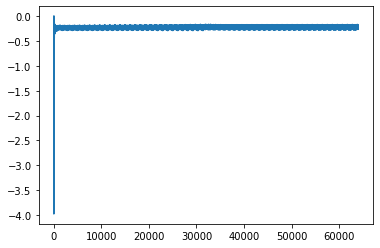

In [1220]:
plt.plot(losses)
plt.show()

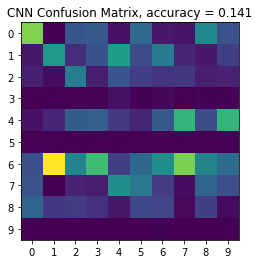

In [1225]:
acc = 0
confusion = np.zeros((10, 10))
num_test = im_test.shape[1]
for i in range(num_test):
    x = im_test[:, [i]].reshape((14, 14, 1), order='F')
    pred1 = conv(x, w_conv, b_conv)  # (14, 14, 3)
    pred2 = relu(pred1)  # (14, 14, 3)
    pred3 = pool2x2(pred2)  # (7, 7, 3)
    pred4 = flattening(pred3)  # (147, 1)
    y = fc(pred4, w_fc, b_fc)  # (10, 1)
    l_pred = np.argmax(y)
    confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1
    if l_pred == label_test[0, i]:
        acc = acc + 1
accuracy = acc / num_test
for i in range(10):
    confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
visualize_confusion_matrix(confusion, accuracy, label_classes, 'CNN Confusion Matrix')

In [976]:
def main_cnn():
    mnist_train = sio.loadmat('./mnist_train.mat')
    mnist_test = sio.loadmat('./mnist_test.mat')
    im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
    im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
    batch_size = 32
    im_train, im_test = im_train / 255.0, im_test / 255.0
    mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
    w_conv, b_conv, w_fc, b_fc = train_cnn(mini_batch_x, mini_batch_y)
    sio.savemat('cnn.mat', mdict={'w_conv': w_conv, 'b_conv': b_conv, 'w_fc': w_fc, 'b_fc': b_fc})
    # could use following two lines to replace above two lines if only want to check results
    # data = sio.loadmat('cnn.mat')
    # w_conv, b_conv, w_fc, b_fc = data['w_conv'], data['b_conv'], data['w_fc'], data['b_fc']
    
    acc = 0
    confusion = np.zeros((10, 10))
    num_test = im_test.shape[1]
    for i in range(num_test):
        x = im_test[:, [i]].reshape((14, 14, 1), order='F')
        pred1 = conv(x, w_conv, b_conv)  # (14, 14, 3)
        pred2 = relu(pred1)  # (14, 14, 3)
        pred3 = pool2x2(pred2)  # (7, 7, 3)
        pred4 = flattening(pred3)  # (147, 1)
        y = fc(pred4, w_fc, b_fc)  # (10, 1)
        l_pred = np.argmax(y)
        confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1
        if l_pred == label_test[0, i]:
            acc = acc + 1
    accuracy = acc / num_test
    for i in range(10):
        confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, accuracy, label_classes, 'CNN Confusion Matrix')